# Generate a sample figure for the DoE CSGF Program Review
This document generates a sample population projection over one year to demonstrate (approximate) seaonality of ESM.

In [1]:
%load_ext autoreload
%autoreload 2

import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

import SpongyMothIPM.meteorology as met
from SpongyMothIPM.config import Config
import SpongyMothIPM.util as util
import SpongyMothIPM.kernels as kernels
import SpongyMothIPM.visualization as viz

## Load Weather Data

In [2]:
df = met.load_daymet_data('../data/mont_st_hilaire/mont_st_hilaire_1980_1991.csv')
low_time = 1
high_time = 13
sample_period = 4
sample_start_time = 1
temps = met.daymet_to_diurnal(df, 
                            low_time, 
                            high_time, 
                            sample_period, 
                            sample_start_time, 365)


config = Config(dtype=torch.float,
                delta_t=sample_period/24)

days = len(temps)//(24//sample_period)

In [ ]:
with torch.no_grad():
    # Build life stages
    prediapause = kernels.Prediapause(
        config, save=True, save_rate=1, mortality=0,
        file_path='../outputs/poster_example/prediapause.csv')
    diapause = kernels.Diapause(
        config, n_bins_I=45, n_bins_D=45, save=True, save_rate=1, mortality=0,
        file_path='../outputs/poster_example/diapause.csv')
    postdiapause = kernels.Postdiapause(
        config, save=True, save_rate=1, mortality=0,
        file_path='../outputs/poster_example/postdiapause.csv')
    first_instar = kernels.FirstInstar(
        config, save=True, save_rate=1, mortality=0, 
        file_path='../outputs/poster_example/first_instar.csv')
    second_instar = kernels.SecondInstar(
        config, save=True, save_rate=1, mortality=0,
        file_path='../outputs/poster_example/second_instar.csv')
    third_instar = kernels.ThirdInstar(
        config, save=True, save_rate=1, mortality=0,
        file_path='../outputs/poster_example/third_instar.csv')
    fourth_instar = kernels.FourthInstar(
        config, save=True, save_rate=1, mortality=0,
        file_path='../outputs/poster_example/fourth_instar.csv')
    male_late_instar = kernels.MaleFifthInstar(
        config, save=True, save_rate=1, mortality=0,
        file_path='../outputs/poster_example/male_late_instar.csv')
    female_late_instar = kernels.FemaleFifthSixthInstar(
        config, save=True, save_rate=1, mortality=0,
        file_path='../outputs/poster_example/female_late_instar.csv')
    male_pupae = kernels.MalePupae(
        config, save=True, save_rate=1, mortality=0,
        file_path='../outputs/poster_example/male_pupae.csv')
    female_pupae = kernels.FemalePupae(
        config, save=True, save_rate=1, mortality=0,
        file_path='../outputs/poster_example/female_pupae.csv')
    adults = kernels.Adult(
        config, save=True, save_rate=1, mortality=0,
        file_path='../outputs/poster_example/adult.csv')

    # Initiate populations
    mu = 0.2
    sigma = 1.1
    total = 10
    empty = 0
    prediapause.init_pop(empty, mu, sigma)
    diapause.init_pop(total, mu, sigma)
    postdiapause.init_pop(empty, mu, sigma)
    first_instar.init_pop(empty, mu, sigma)
    second_instar.init_pop(empty, mu, sigma)
    third_instar.init_pop(empty, mu, sigma)
    fourth_instar.init_pop(empty, mu, sigma)
    male_late_instar.init_pop(empty, mu, sigma)
    female_late_instar.init_pop(empty, mu, sigma)
    male_pupae.init_pop(empty, mu, sigma)
    female_pupae.init_pop(empty, mu, sigma)
    adults.init_pop(empty, mu, sigma)

    # Run Model
    start_year = temps['year'].min()
    end_year = temps['year'].max()
    start = 0
    for year in range(start_year, end_year+1):
        print(f"Starting year {year}")
        days = temps.loc[temps['year'] == year, 'yday'].max()
        for day in range(1, days+1):
            end = start + (24//sample_period)
            day_temps = temps.iloc[start:end]
            transfers = prediapause.run_one_step(day_temps)
            transfers = diapause.run_one_step(day_temps, transfers)
            transfers = postdiapause.run_one_step(day_temps, transfers)
            transfers = first_instar.run_one_step(day_temps, transfers)
            transfers = second_instar.run_one_step(day_temps, transfers)
            transfers = third_instar.run_one_step(day_temps, transfers)
            transfers_dif = fourth_instar.run_one_step(day_temps, transfers)
            transfers = male_late_instar.run_one_step(day_temps, transfers_dif/2)
            to_adult = male_pupae.run_one_step(day_temps, transfers)
            transfers = female_late_instar.run_one_step(day_temps, transfers_dif/2)
            to_adult += female_pupae.run_one_step(day_temps, transfers)
            transfers = adults.run_one_step(day_temps, to_adult)
            prediapause.add_transfers(transfers/2)

            start = end

Starting year 1980


## Visualization

In [52]:
df_prediapause = pd.read_csv('../outputs/poster_example/prediapause.csv', header=0, index_col=[0,1])
df_diapause = pd.read_csv('../outputs/poster_example/diapause.csv', header=0, index_col=[0,1])
df_postdiapause = pd.read_csv('../outputs/poster_example/postdiapause.csv', header=0, index_col=[0,1])
df_first_instar = pd.read_csv('../outputs/poster_example/first_instar.csv', header=0, index_col=[0,1])
df_second_instar = pd.read_csv('../outputs/poster_example/second_instar.csv', header=0, index_col=[0,1])
df_third_instar = pd.read_csv('../outputs/poster_example/third_instar.csv', header=0, index_col=[0,1])
df_fourth_instar = pd.read_csv('../outputs/poster_example/fourth_instar.csv', header=0, index_col=[0,1])
df_male_late_instar = pd.read_csv('../outputs/poster_example/male_late_instar.csv', header=0, index_col=[0,1])
df_female_late_instar = pd.read_csv('../outputs/poster_example/female_late_instar.csv', header=0, index_col=[0,1])
df_male_pupae = pd.read_csv('../outputs/poster_example/male_pupae.csv', header=0, index_col=[0,1])
df_female_pupae = pd.read_csv('../outputs/poster_example/female_pupae.csv', header=0, index_col=[0,1])
df_adult = pd.read_csv('../outputs/poster_example/adult.csv', header=0, index_col=[0,1])

In [110]:
dfs = [df_prediapause,
       df_diapause,
       df_postdiapause,
       df_first_instar,
       df_second_instar,
       df_third_instar,
       df_fourth_instar,
       df_male_late_instar,
       df_female_late_instar,
       df_male_pupae,
       df_female_pupae,
       df_adult]
names = ['Prediapause',
         'Diapause',
         'Postdiapause',
         'First Instar',
         'Second Instar',
         'Third Instar',
         'Fourth Instar',
         'Male Fifth Instar',
         'Female Fifth/Sixth Instar',
         'Male Pupae',
         'Female Pupae',
         'Adult']
styles = [{'color':'blue', 'linestyle':'dotted', 'linewidth':5}, # Prediapause
          {'color':'blue', 'linestyle':'solid', 'linewidth':5}, # Diapause
          {'color':'blue', 'linestyle':'dashed', 'linewidth':5}, # Postdiapause
          {'color':'purple', 'linestyle':'dotted', 'linewidth':5}, # First Instar
          {'color':'purple', 'linestyle':'dashed', 'dashes':(3, 2, 1, 2), 'linewidth':5}, # Second Instar
          {'color':'purple', 'linestyle':'dashed', 'linewidth':5}, # Third Instar
          {'color':'purple', 'linestyle':'solid', 'linewidth':5}, # Fourth Instar
          {'color':'darkgreen', 'linestyle':'dashed', 'linewidth':5}, # Male Fifth Instar
          {'color':'darkgreen', 'linestyle':'solid', 'linewidth':5}, # Female Fifth/Sixth Instar
          {'color':'brown', 'linestyle':'dashed', 'linewidth':5}, # Male Pupae
          {'color':'brown', 'linestyle':'solid', 'linewidth':5}, # Female Pupae
          {'color':'black', 'linestyle':'solid', 'linewidth':5}, # Adult
          ]

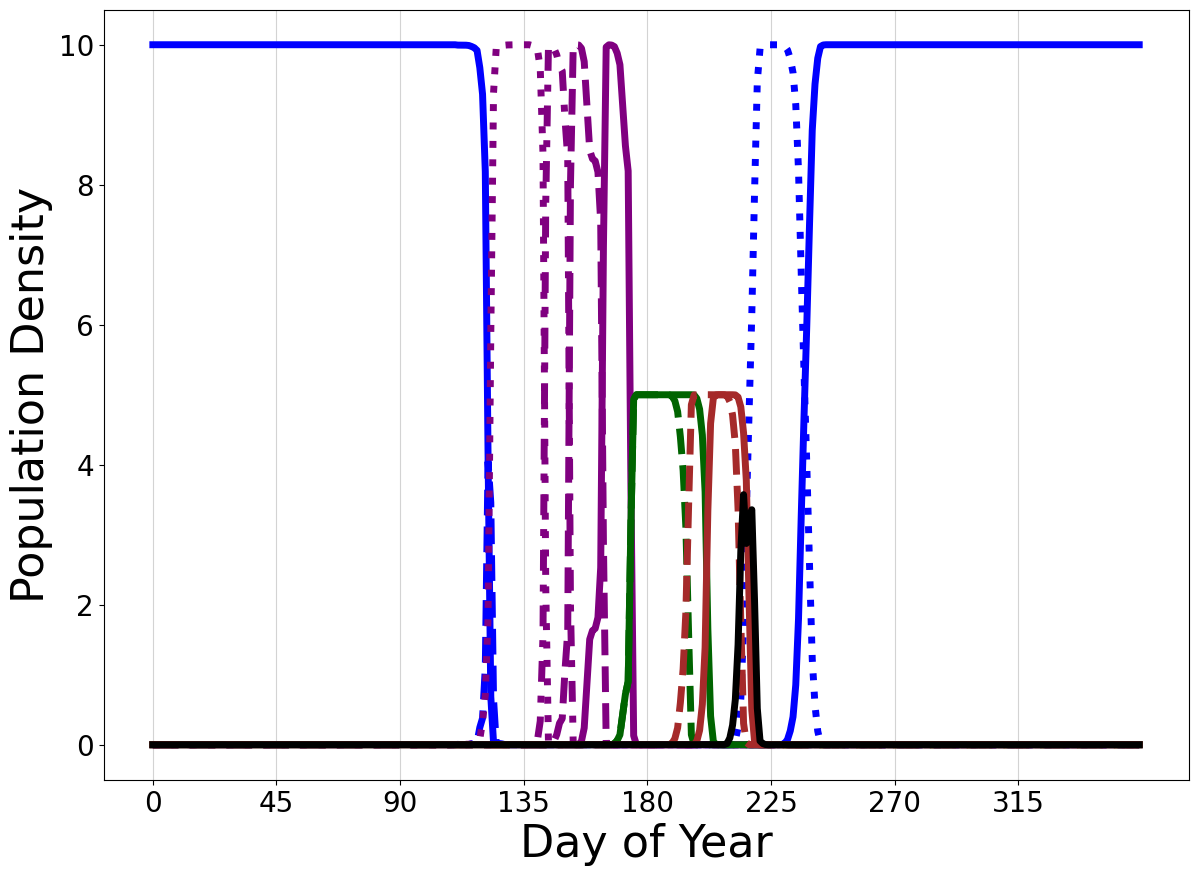

In [111]:
fig, ax = plt.subplots(figsize=(14, 10))

viz.plot_abundances(ax, dfs, names, styles, tick_freq=45, label_fontsize=32)